<a href="https://colab.research.google.com/github/akshay1710/FlowerClassification/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Flower Detection using Deeplearning techniques

#Import all Library which you required

In [14]:
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### Flower Dataset download on the kaggle

In [15]:
cd /content/drive/MyDrive/DeeplearningAi/Classification

/content/drive/MyDrive/DeeplearningAi/Classification


In [16]:
#This library use  for download dataset on kaggle using Api token
!pip install opendatasets --upgrade --quiet


In [17]:
%ls

'Classification-pbs (1).ipynb'   FashionMNIST.ipynb           kaggle.json
 Classification-pbs.ipynb        FlowerClassification.ipynb
 data/                           flowers-recognition/


In [18]:
%cd /content/drive/MyDrive/DeeplearningAi/Classification

/content/drive/MyDrive/DeeplearningAi/Classification


In [19]:
import opendatasets as od

In [20]:
od.download('https://www.kaggle.com/alxmamaev/flowers-recognition')

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


## Import Data Into Pytorch
Use the ImageFolder class from torchvision

In [21]:
data_dir = './flowers-recognition/flowers'
file_name = os.path.basename(data_dir)






data  = [len(os.listdir(data_dir + '/' + i)) for i in os.listdir(data_dir)]
data = sum(data)
class_names = os.walk(data_dir).__next__()[1]
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [22]:
import os

In [23]:
datalist = os.listdir(data_dir)
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

daisy : 764
dandelion : 1052
rose : 784
sunflower : 733
tulip : 984


## Data Augmentation using Pytorch

In [24]:
from torchvision.transforms.transforms import RandomAffine
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.Resize((224)), 
                         tt.RandomHorizontalFlip(p = 0.5), 
                         tt.RandomResizedCrop(224, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.RandomVerticalFlip(p=0.5),
                         #tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])


##Creating a Custom PyTorch Dataset

In [25]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files_path, self.labels, self.length, self.classes = self.read_data_set()
        
  

    def __len__(self):
        return self.length

    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.root_dir).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.root_dir, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)
        return all_img_files, all_labels, len(all_img_files), class_names

    def __getitem__(self, item):
        image = Image.open(self.image_files_path[item])
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        return  (image, self.labels[item])


In [26]:
dataset = CustomDataset(data_dir, train_tfms)

In [27]:
dataset.classes


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rose


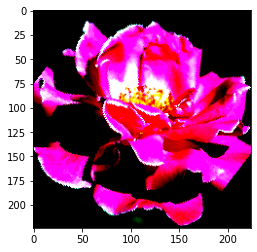

In [28]:
import matplotlib.pyplot as plt
img, label = dataset[2012]
%matplotlib inline
print(class_names[label])
plt.imshow(img.permute(1,2,0))

## Creating Training and Validation Sets

In [29]:
val_pct = 0.1
val_size = int(len(dataset) * val_pct)
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [30]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
print(type(train_ds))

<class 'torch.utils.data.dataset.Subset'>


In [31]:
from torch.utils.data import DataLoader
batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

In [32]:
train_dl.__dict__

{'_DataLoader__initialized': True,
 '_DataLoader__multiprocessing_context': None,
 '_IterableDataset_len_called': None,
 '_dataset_kind': 0,
 '_iterator': None,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f06eb508290>,
 'batch_size': 128,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate>,
 'dataset': <torch.utils.data.dataset.Subset at 0x7f06eb4ac950>,
 'drop_last': False,
 'generator': None,
 'num_workers': 4,
 'persistent_workers': False,
 'pin_memory': True,
 'prefetch_factor': 2,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f06eb508810>,
 'timeout': 0,
 'worker_init_fn': None}

In [33]:
from torchvision.utils import make_grid
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


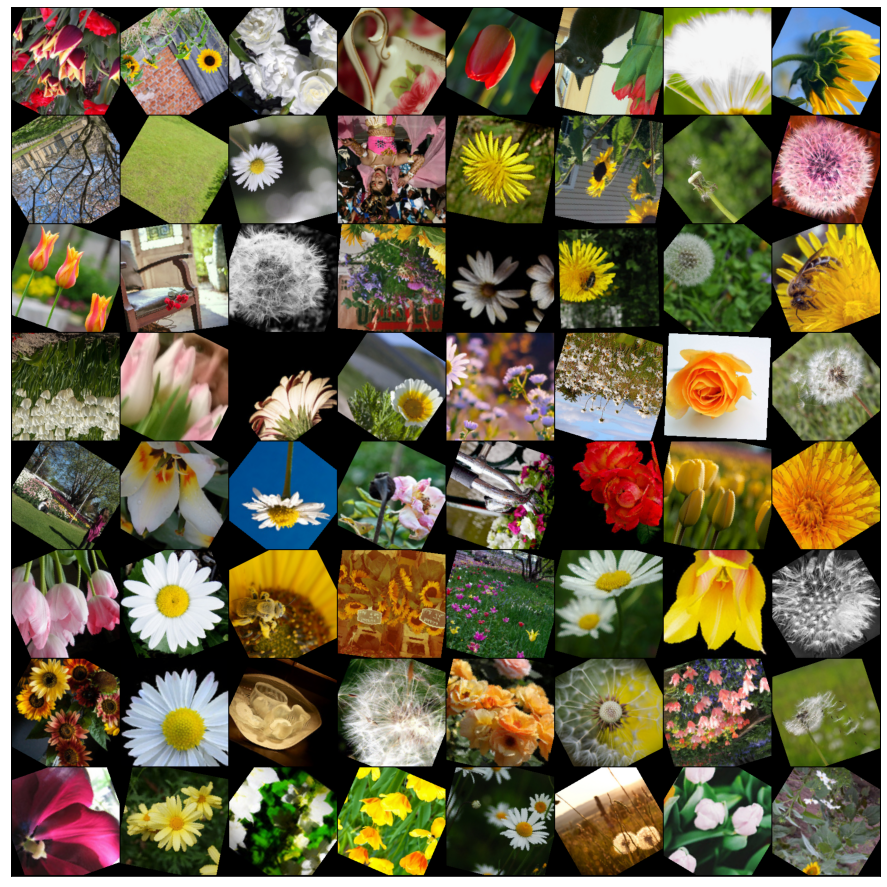

In [34]:
show_batch(train_dl)

In [35]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu') 

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        print('enter in isinstance')
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [36]:
torch.cuda.is_available()

True

In [37]:
device = get_default_device()
device

device(type='cuda')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
train_dl

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Modifying a Pretrained Model (ResNet50)

In [40]:
from torchvision import models

class ResnetModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        # self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        self.network.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(self.network.fc.in_features, num_classes))

    def forward(self, xb):
        return self.network(xb)

In [41]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [42]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [44]:
model = ResnetModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [45]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.22897273302078247, 'val_loss': 1.719618320465088}]

In [46]:
out = model.parameters()
out

<generator object Module.parameters at 0x7f06e18fef50>

###  Finetuning the Pretrained Model

In [47]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [48]:
history += fit(6, 1e-4, model, train_dl, valid_dl, torch.optim.Adam)

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.6337, val_loss: 0.2949, val_acc: 0.8905


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2644, val_loss: 0.1828, val_acc: 0.9459


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1916, val_loss: 0.1754, val_acc: 0.9338


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1584, val_loss: 0.1808, val_acc: 0.9444


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1177, val_loss: 0.1685, val_acc: 0.9352


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1042, val_loss: 0.1495, val_acc: 0.9517


In [49]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

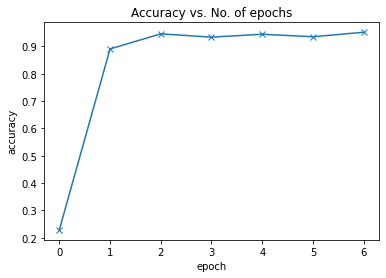

In [50]:
plot_accuracies(history)

In [51]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history[:]]
    val_losses = [x['val_loss'] for x in history[:]]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

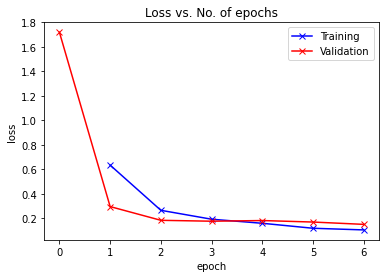

In [52]:
plot_losses(history)

In [55]:
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
  
    return classes[preds[0].item()]

In [56]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print(dataset.classes)
    print('Target:',  dataset.classes[label])
    print('Prediction:', pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Target: sunflower
Prediction: sunflower


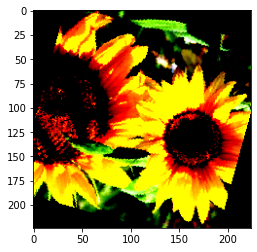

In [57]:
show_image_prediction(*valid_ds[45])